In [49]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/diogo/programs/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import obspy as op
import glob
import os
import fnmatch
import shutil
import matplotlib.gridspec as gridspec
from scipy import signal,stats,spatial,misc
from obspy.taup import TauPyModel
import time
from IPython import display
import matplotlib.gridspec as gridspec
from obspy.clients.fdsn import Client
from obspy.clients.iris import Client as OldIris_Client
from obspy.core.util import NamedTemporaryFile
import matplotlib.mlab as mlab
import itertools
from obspy import UTCDateTime
from matplotlib.cbook import get_sample_data
from mpl_toolkits.basemap import Basemap
from matplotlib.ticker import FormatStrFormatter


<h2 align="center">Recolhendo as listas com os grupos de BAZ das Funções do Receptor</h2>

In [51]:
STA = 'GRJU'

In [52]:
#pasta = '/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/test_discretization/earth_model_1/GRJU/'
pasta = '/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/test_discretization/earth_model_2/GRJU/'
#pasta = '/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/test_discretization/earth_model_3/GRJU/'


In [53]:
RF_list_BAZ = []
RF_list_BAZS = []

for root, dirs, files in os.walk(pasta):
    for datafile in files:
        if datafile.startswith('urayl.sac'):
            RF_list_BAZ.append(os.path.join(root, datafile))
RF_list_BAZS = sorted(RF_list_BAZ)

In [54]:
JI_folder_list = []
JI_BAZ_list = []
JI_BAZ = [] 
JI_folder_list = [i.split('urayl')[0] for i in RF_list_BAZS]
JI_BAZ_list = [i.split('/')[11] for i in JI_folder_list]
JI_BAZ = [i.split('BAZ_')[1] for i in JI_BAZ_list]

<h2 align="center">Transformando os arquivos das pastas para poder Plotar a Inversão Conjunta</h2>

In [55]:
for i,j in enumerate(JI_folder_list):
    os.chdir(j)
    os.system('sac2xy 2 model.0.vs > model_0_vs.txt')
    os.system('sac2xy 2 model.9.vs > model_9_vs.txt')
    os.system('sac2xy 2 syn.9ur.disp > syn_9ur.txt')
    os.system('sac2xy 2 urayl.sac > urayl.txt')

In [56]:
model_joint_0 = [[] for x in range(len(JI_folder_list))]
model_joint_9 = [[] for x in range(len(JI_folder_list))]

for i,j in enumerate(JI_folder_list):
    with open(j+'model_0_vs.txt') as inputfile:
        for line in inputfile:
            model_joint_0[i].append(line.strip().split())
            
for i,j in enumerate(JI_folder_list):
    with open(j+'model_9_vs.txt') as inputfile:
        for line in inputfile:
            model_joint_9[i].append(line.strip().split())
            
vs_9 = [[] for x in range(len(JI_folder_list))]
prof_9 = [[] for x in range(len(JI_folder_list))]

for i,j in enumerate(model_joint_9):
    for k,l in enumerate(j):
        vs_9[i].append(float(l[0]))
        prof_9[i].append(float(l[1]))

vs_0 = [[] for x in range(len(JI_folder_list))]
prof_0 = [[] for x in range(len(JI_folder_list))]
for i,j in enumerate(model_joint_0):
    for k,l in enumerate(j):
        vs_0[i].append(float(l[0]))
        prof_0[i].append(float(l[1]))

In [57]:
RF_0_10 = [[] for x in range(len(JI_folder_list))]
RF_10 = [[] for x in range(len(JI_folder_list))]

for i,j in enumerate(JI_folder_list):
    if os.path.isfile(j+'syn.9lf'+JI_BAZ[i]+'.rftn') == True:        
        RF_0_10[i] = op.read(j+'rftn_lf'+JI_BAZ[i]+'.'+STA)
        RF_10[i] = op.read(j+'syn.9lf'+JI_BAZ[i]+'.rftn')
    else:
        RF_0_10[i] = []
        RF_10[i] = []

In [58]:
RF_0_25 = [[] for x in range(len(JI_folder_list))]
RF_25 = [[] for x in range(len(JI_folder_list))]


for i,j in enumerate(JI_folder_list):
    if os.path.isfile(j+'syn.9hf'+JI_BAZ[i]+'.rftn') == True:        
        RF_0_25[i] = op.read(j+'rftn_hf'+JI_BAZ[i]+'.'+STA)
        RF_25[i] = op.read(j+'syn.9hf'+JI_BAZ[i]+'.rftn')
    else:
        RF_0_25[i] = []
        RF_25[i] = []

In [59]:
model_joint_0_vg_per = [[] for x in range(len(JI_folder_list))]
model_joint_9_vg_per = [[] for x in range(len(JI_folder_list))]

group_ray_periods_0 = [[] for x in range(len(JI_folder_list))]
group_ray_amp_0 = [[] for x in range(len(JI_folder_list))]

group_ray_periods_9 = [[] for x in range(len(JI_folder_list))]
group_ray_amp_9 = [[] for x in range(len(JI_folder_list))]

for i,j in enumerate(JI_folder_list):
    with open(j+'urayl.txt') as inputfile:
        for line in inputfile:
            model_joint_0_vg_per[i].append(line.strip().split())
            
for i,j in enumerate(JI_folder_list):
    with open(j+'syn_9ur.txt') as inputfile:
        for line in inputfile:
            model_joint_9_vg_per[i].append(line.strip().split())

for i,j in enumerate(model_joint_0_vg_per):
    for k,l in enumerate(j):
        group_ray_periods_0[i].append(float(l[0]))
        group_ray_amp_0[i].append(float(l[1]))

for i,j in enumerate(model_joint_9_vg_per):
    for k,l in enumerate(j):
        group_ray_periods_9[i].append(float(l[0]))
        group_ray_amp_9[i].append(float(l[1]))

In [60]:
num_RF_10 = [[] for x in range(len(JI_folder_list))]

BAZ_10 = [[] for x in range(len(JI_folder_list))]
BAZ_10_error = [[] for x in range(len(JI_folder_list))]

RP_10 = [[] for x in range(len(JI_folder_list))]
RP_10_error = [[] for x in range(len(JI_folder_list))]

for i,j in enumerate(JI_folder_list):
    if os.path.isfile('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_1.0/'+STA+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA+'_stacking_mean_std_10.txt') == True:        
        num_RF_10[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_1.0/'+STA+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA+'_stacking_mean_std_10.txt')[0]
        BAZ_10[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_1.0/'+STA+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA+'_stacking_mean_std_10.txt')[1]
        BAZ_10_error[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_1.0/'+STA+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA+'_stacking_mean_std_10.txt')[2]
        RP_10[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_1.0/'+STA+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA+'_stacking_mean_std_10.txt')[3]
        RP_10_error[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_1.0/'+STA+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA+'_stacking_mean_std_10.txt')[4]   
    else:
        num_RF_10[i] = 0
        BAZ_10[i] = []
        BAZ_10_error[i] = []
        RP_10[i] = []
        RP_10_error[i] = []


In [61]:
num_RF_25 = [[] for x in range(len(JI_folder_list))]

BAZ_25 = [[] for x in range(len(JI_folder_list))]
BAZ_25_error = [[] for x in range(len(JI_folder_list))]

RP_25 = [[] for x in range(len(JI_folder_list))]
RP_25_error = [[] for x in range(len(JI_folder_list))]


for i,j in enumerate(JI_folder_list):
    if os.path.isfile('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_2.5/'+STA+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA+'_stacking_mean_std_25.txt') == True:        
        num_RF_25[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_2.5/'+STA+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA+'_stacking_mean_std_25.txt')[0]
        BAZ_25[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_2.5/'+STA+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA+'_stacking_mean_std_25.txt')[1]
        BAZ_25_error[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_2.5/'+STA+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA+'_stacking_mean_std_25.txt')[2]
        RP_25[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_2.5/'+STA+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA+'_stacking_mean_std_25.txt')[3]
        RP_25_error[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_2.5/'+STA+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA+'_stacking_mean_std_25.txt')[4]
    else:
        num_RF_25[i] = 0
        BAZ_25[i] = []
        BAZ_25_error[i] = []
        RP_25[i] = []
        RP_25_error[i] = []

<h2 align="center">Calculando o erro da inversão conjunta para cada estação</h2>

In [62]:
peso = []
for i,j in enumerate(num_RF_10):
    if num_RF_10[i] == []:        
        peso.append(num_RF_25[i])
    elif num_RF_25 == []:
        peso.append(num_RF_10[i])
    else:
        peso.append(j+num_RF_25[i])

In [63]:
peso = []
for i,j in enumerate(num_RF_10):
    if num_RF_25[i] == []:        
        peso.append(num_RF_10[i])
    elif num_RF_10 == []:
        peso.append(num_RF_25[i])
    else:
        peso.append(j+num_RF_25[i])

In [64]:
peso_sum = sum(peso)

In [65]:
vs_media = np.average(vs_9, axis=0,weights=peso)
prof_media = prof_9[0]

In [66]:
vs_media = np.average(vs_9, axis=0,weights=peso)

In [67]:
vs_error = [[] for x in range(len(JI_folder_list))]
for i,j in enumerate(vs_9):
    vs_error[i].append(j-vs_media)

In [68]:
vs_error_std = [[] for x in range(len(JI_folder_list))]
for i,j in enumerate(vs_error):
    vs_error_std[i].append(2*np.std(j))

In [69]:
vs_error_std_sta = 2*np.mean(vs_error_std)

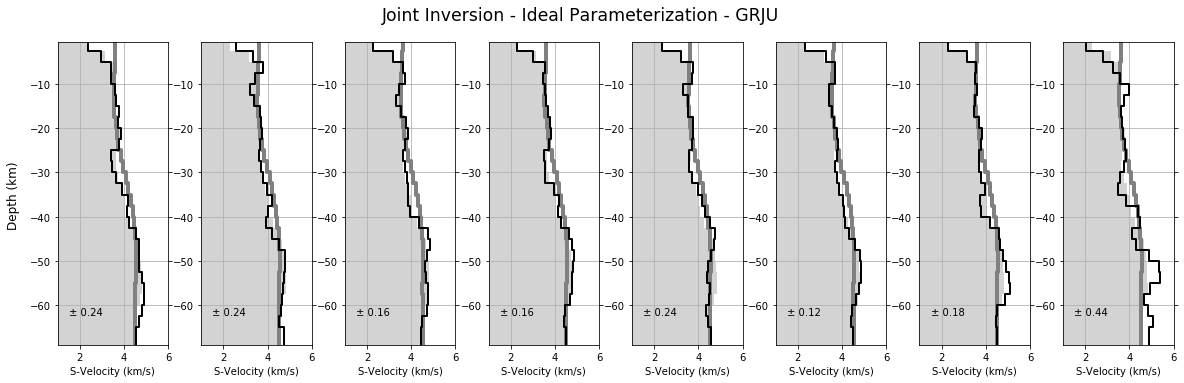

In [70]:
fig = plt.figure(figsize=(20,10),facecolor='white')
gs1 = gridspec.GridSpec(1,len(JI_folder_list),wspace=0.3, hspace=0.3)

for i,j in enumerate(JI_folder_list):
    ax1 = fig.add_subplot(gs1[i])
    ax1.fill_betweenx(prof_media,0,vs_media,where=[i >=0 and i <=5 for i in vs_media],facecolor='lightgray')
    ax1.step(vs_0[i],prof_0[i],'grey',lw= 4, where='post',label='Initial Model')
    ax1.step(vs_9[i],prof_9[i],'k',lw= 2, where='post',label='Final Model')
    plt.tick_params(top='off', bottom='on', left='on', right='on')
    ax1.set_aspect(0.2)
    ax1.set_xlim([1,6])
    ax1.set_ylim([-69,-0.5])
    ax1.set_xlabel('S-Velocity (km/s)')
    ax1.axes.grid('on')
    ax1.text(0.1,0.1,'\xb1 '+str("{0:.2f}".format(*vs_error_std[i])), transform=ax1.transAxes, fontsize=10)

#fig.text(0.35, 0.75, "Joint Inversion - Coarsed Parameterization - GRJU", va='center',fontsize='xx-large')
#fig.text(0.35, 0.75, "Joint Inversion - Fair Parameterization - GRJU", va='center',fontsize='xx-large')
fig.text(0.35, 0.75, "Joint Inversion - Ideal Parameterization - GRJU", va='center',fontsize='xx-large')
fig.text(0.09, 0.5, 'Depth (km)', va='center', rotation='vertical',fontsize='large')   
fig.savefig(pasta+'S_velocity_models.pdf')


In [71]:
np.savetxt(pasta+'mean_velocity_model.txt',np.c_[vs_media,prof_media])
np.savetxt(pasta+'initial_velocity_model.txt',np.c_[vs_0[0],prof_0[0]])

<h2 align="center">Plotando a inversão conjunta entre as Funções do Receptor e as Curvas de Dispersão</h2>

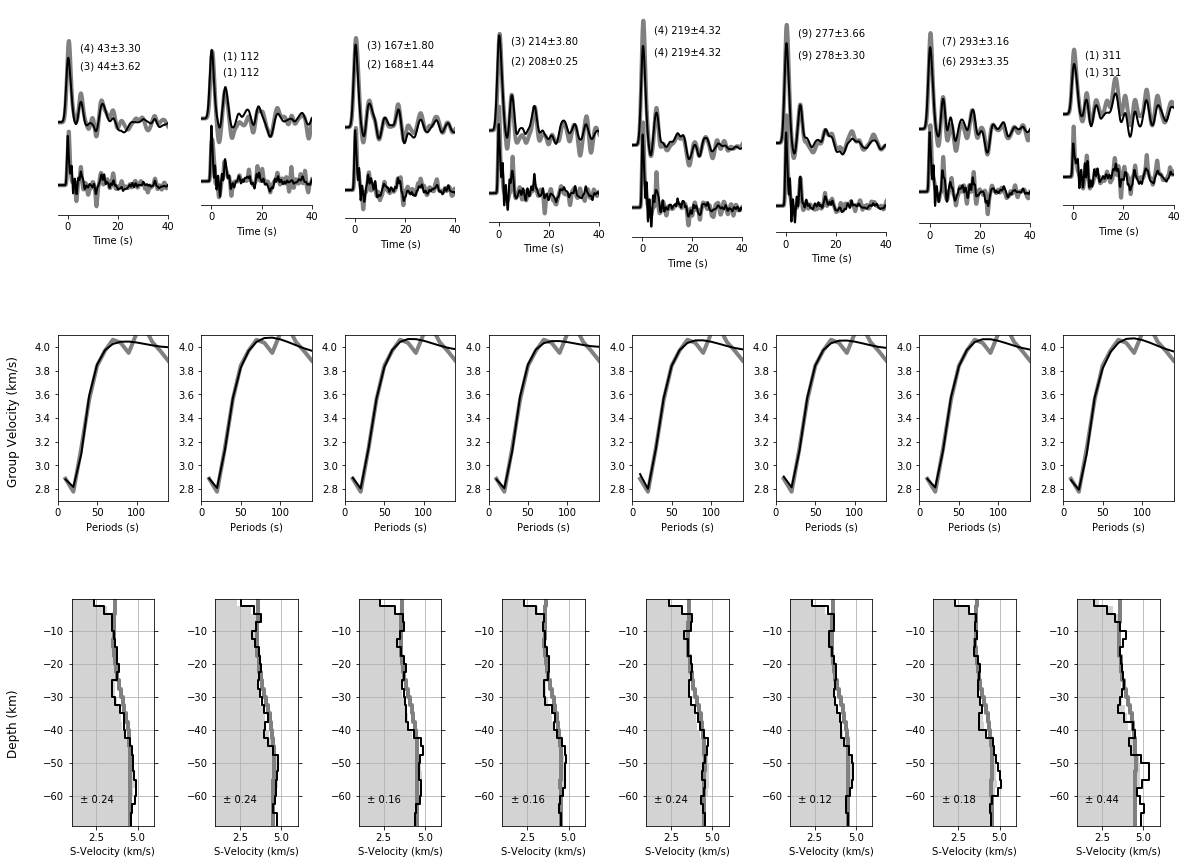

In [72]:
fig = plt.figure(figsize=(20,15),facecolor='white')
gs1 = gridspec.GridSpec(3,len(JI_folder_list),wspace=0.3, hspace=0.3)

for i,j in enumerate(JI_folder_list):
    if RF_0_25[i] != []:
        ax4 = fig.add_subplot(gs1[0,i])
        ax4.plot(RF_0_25[i][0].times()-10,1.5*RF_0_25[i][0].data,'grey',lw=4,label='Observed')
        ax4.plot(RF_25[i][0].times()-10,1.5*RF_25[i][0].data,'k',lw=2,label='Predicted')
        ax4.set_xlim(-4,40)
        ax4.set_xlabel('Time (s)')
        ax4.set_yticks([])
        ax4.set_aspect(50)
        ax4.spines['right'].set_visible(False)
        ax4.spines['left'].set_visible(False)
        ax4.spines['top'].set_visible(False)
        if str("{0:.0f}".format(num_RF_25[i])) != '1':        
            ax4.text(0.2, 0.90, '('+str("{0:.0f}".format(num_RF_25[i]))+') '+str("{0:.0f}".format(BAZ_25[i]))+str('\xb1')+str("{0:.2f}".format(BAZ_25_error[i])), transform=ax4.transAxes, fontsize=10)
        else:
            ax4.text(0.2, 0.90, '('+str("{0:.0f}".format(num_RF_25[i]))+') '+str("{0:.0f}".format(BAZ_25[i])), transform=ax4.transAxes, fontsize=10)

        
    if RF_0_10[i] != []:        
        ax4 = fig.add_subplot(gs1[0,i])
        ax4.plot(RF_0_10[i][0].times()-10,0.5+1.5*RF_0_10[i][0].data,'grey',lw=4,label='Observed')
        ax4.plot(RF_10[i][0].times()-10,0.5+1.5*RF_10[i][0].data,'k',lw=2,label='Predicted')
        ax4.set_xlim(-4,40)
        ax4.set_xlabel('Time (s)')
        ax4.set_yticks([])
        ax4.set_aspect(50)
        ax4.spines['right'].set_visible(False)
        ax4.spines['left'].set_visible(False)
        ax4.spines['top'].set_visible(False)
        if str("{0:.0f}".format(num_RF_10[i])) != '1':        
            ax4.text(0.2, 0.80, '('+str("{0:.0f}".format(num_RF_10[i]))+') '+str("{0:.0f}".format(BAZ_10[i]))+str('\xb1')+str("{0:.2f}".format(BAZ_10_error[i])), transform=ax4.transAxes, fontsize=10)
        else:
            ax4.text(0.2, 0.80, '('+str("{0:.0f}".format(num_RF_10[i]))+') '+str("{0:.0f}".format(BAZ_10[i])), transform=ax4.transAxes, fontsize=10)
            



    ax5 = fig.add_subplot(gs1[1,i])
    ax5.plot(group_ray_periods_0[i],group_ray_amp_0[i],'grey',lw=4,label='Observed')
    ax5.plot(group_ray_periods_9[i],group_ray_amp_9[i],'k',lw=2,label='Predicted')
    ax5.set_xlim(0,140)
    ax5.set_ylim(2.7,4.1)
    ax5.set_xlabel('Periods (s)')
    ax5.set_aspect(150)
    ax5.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax5.get_yaxis().set_tick_params(which='both', direction='out')
    
    ax1 = fig.add_subplot(gs1[2,i])
    ax1.fill_betweenx(prof_media,0,vs_media,where=[i >=0 and i <=5 for i in vs_media],facecolor='lightgray')
    ax1.step(vs_0[i],prof_0[i],'grey',lw= 4, where='post',label='Initial Model')
    ax1.step(vs_9[i],prof_9[i],'k',lw= 2, where='post',label='Final Model')
    plt.tick_params(top='off', bottom='on', left='on', right='on')
    ax1.text(0.1,0.1,'\xb1 '+str("{0:.2f}".format(*vs_error_std[i])), transform=ax1.transAxes, fontsize=10)
    ax1.set_aspect(0.2)
    ax1.set_xlim([1,6])
    ax1.set_ylim([-69,-0.5])
    ax1.set_xlabel('S-Velocity (km/s)')
    ax1.axes.grid('on') 


#    ax1.legend(loc=3)
fig.text(0.09, 0.22, 'Depth (km)', va='center', rotation='vertical',fontsize='large')
fig.text(0.09, 0.5, 'Group Velocity (km/s)', va='center', rotation='vertical',fontsize='large')
fig.savefig(pasta+'Joint_inversion.pdf')
fig.savefig(pasta+'Joint_inversion.png')